## VarQITE for Combinatorial Problem in High Energy Physics
-----

In [1]:
### Visualization
import matplotlib.pyplot as plt

### Importing MadGraph Data
import gzip
import xml.etree.ElementTree as ET

### Quantum Algorithm
import pennylane as qml
from pennylane import numpy as np

### Utilities
from tqdm import tqdm
from itertools import combinations

------

### Extracting Data to use

In [2]:
### Function to parse LHE file and extract final state pdg id & 4 - momentum 
def lhe_4momenta(file_path):

    with gzip.open(file_path, 'rt') as f:
        tree = ET.parse(f)
        root = tree.getroot()

        events = []
        for event in root.findall(".//event"):
            lines = event.text.strip().split("\n")
            event_data = []
            
            for line in lines[1:]:  # Skip first line (metadata)
                parts = line.split()
                pdg_id = int(parts[0])  # PDG particle ID
                status = int(parts[1])  # Status code
                
                if status == 1:  # Final state particles (jets, leptons, etc.)
                    px, py, pz, E = map(float, parts[6:10])  # 4-momentum
                    event_data.append((pdg_id, px, py, pz, E))
            
            events.append(event_data)
    
    return events

### Function to choose one specific event
def event_selection(events, idx):
    return events[idx-1]

### Construct the 4-momenta of the specific event
def momentum_vector(event):
    p = list()
    for _, px, py, pz, E in event:
        p.append([E, px, py, pz]) # 4-momentum in (E, p_x, p_y, p_z)
    return np.array(p)


In [3]:
### PDG Particles ID
PDG_ID = {
    # Quarks
    1: 'down', -1: 'anti-down',
    2: 'up', -2: 'anti-up',
    3: 'strange', -3: 'anti-strange',
    4: 'charm', -4: 'anti-charm',
    5: 'bottom', -5: 'anti-bottom',
    6: 'top', -6: 'anti-top',

    # Leptons
    11: 'electron', -11: 'positron',
    12: 'electron neutrino', -12: 'anti-electron neutrino',
    13: 'muon', -13: 'anti-muon',
    14: 'muon neutrino', -14: 'anti-muon neutrino',
    15: 'tau', -15: 'anti-tau',
    16: 'tau neutrino', -16: 'anti-tau neutrino',

    # Gauge Bosons
    21: 'gluon',
    22: 'photon',
    23: 'Z boson',
    24: 'W+ boson', -24: 'W- boson',

    # Higgs Bosons
    25: 'Higgs (H1^0)',
    35: 'Higgs (H2^0)',
    45: 'Higgs (H3^0)',
    36: 'Pseudoscalar Higgs (A1^0)', -36: 'anti-Pseudoscalar Higgs (A1^0)',
    46: 'Pseudoscalar Higgs (A2^0)', -46: 'anti-Pseudoscalar Higgs (A2^0)',
    37: 'Charged Higgs (H+)', -37: 'Charged Higgs (H-)',

    # Graviton
    39: 'Graviton'
}

-----

### Hamiltonian

In [4]:
# Calculating the coefficients for the hamiltonian

### Inner product of the 4-momenta
def P_ij(i,j, event):
    _, px_i, py_i, pz_i, E_i = event[i]
    _, px_j, py_j, pz_j, E_j = event[j]
    pij = E_i * E_j - px_i * px_j - py_i * py_j - pz_i * pz_j
    return pij

### Construct (n_f * n_f) matrix with the inner product of the final states' 4-momenta
def P_matrix(event):
    
    P = np.zeros((len(event), (len(event))))

    for i in range(len(event)):
        for j in range(len(event)):
            P[i, j] = P_ij(i, j, event)

    return P

### Construct J matrix (n_f * n_f)
def J_matrix(P):
    return np.einsum('ik,jl->ij', P, P)

### Calculation of hyperparameter lambda
def get_lambda(P, J):
    min_J = np.min(J)
    max_P = np.max(P)
    return min_J / max_P

### Construct K tensor (n_f * n_f * n_f * n_f)
def K_tensor(P, J):
    return np.einsum('ij, kl->ijkl', J, P)


In [5]:
def build_hamiltonian(event, ham_type):
    n_f = len(event)    # fianl state particles

    # Matrix and Tensor
    P = P_matrix(event)
    J = J_matrix(P)
    K = K_tensor(P,J)
    lamb = get_lambda(P, J)

    if ham_type == 'H0':
        coeff = list()
        ops = list()
        for u in range(n_f):
            for v in range(n_f):
                coeff.append(J[u, v])
                ops.append(qml.PauliZ(u) @ qml.PauliZ(v))
        

    elif ham_type == 'H1':
        coeff = list()
        ops = list()
        for u in range(n_f):
            for v in range(n_f):
                coeff.append(J[u, v] + 1/2 * lamb * P[u, v])
                ops.append(qml.PauliZ(u) @ qml.PauliZ(v))
    
    elif ham_type == 'H2':
        quad_coeff = list()
        quad_ops = list()
        quart_coeff = list()
        quart_ops = list()

        P_sum = np.einsum('ij->', P)

        for u in range(n_f):
            for v in range(n_f):
                quad_coeff.append(P_sum * J[u, v])
                quad_ops.append(qml.PauliZ(u) @ qml.PauliZ(v))
        
        for i in range(n_f):
            for j in range(n_f):
                for k in range(n_f):
                    for l in range(n_f):
                        quart_coeff.append(K[i,j,k,l])
                        quart_ops.append(qml.PauliZ(i) @ qml.PauliZ(j) @ qml.PauliZ(k) @ qml.PauliZ(l))

        coeff = quad_coeff + quart_coeff
        ops = quad_ops + quart_ops


    else:
        raise ValueError("Unsupported Hamiltonian Type")

    ham = qml.Hamiltonian(coeff, ops)
    ham = qml.simplify(ham)
    coeff, ops = ham.terms()

    norm_term = np.sum(coeff[1:])
    norm_coeff = coeff / norm_term

    return qml.Hamiltonian(norm_coeff[1:], ops[1:])


In [6]:
### File path
lhe_file_path = "/Users/heechanyi/Desktop/QITE Jet Clustering/VarQITE for HEP/Data/tt_bar_6j.lhe.gz"

# Extract 4-momentum data (10000 Events)
events = lhe_4momenta(lhe_file_path)

#event_idx = np.random.randint(10000)
event_idx = 447
event = event_selection(events, event_idx)

ham = build_hamiltonian(event, 'H0')

------

In [7]:
### Fully Connected Ansatz
def Ansatz1(qubits, thetas):
        edges = list(combinations(qubits, 2))

        for j in qubits:
                qml.Hadamard(wires= j)

        i = 0
        for _, (u, v) in enumerate(edges):
                qml.CNOT(wires=[u, v])
                qml.RY(thetas[i], wires= v)
                qml.CNOT(wires=[u, v])
                i += 1

In [11]:
def pyramid_pairs(lst):
    result = []
    for i in range(len(lst)-1, 0, -1):
        result.extend([(lst[j], lst[j+1]) for j in range(i)])
    return result

def gate_i(n, wire):
        theta = 2*np.arccos(np.sqrt(1/n))
        qml.CNOT(wires = [wire[0], wire[1]])
        qml.CRY(theta, wires = [wire[1], wire[0]])
        qml.CNOT(wires = [wire[0], wire[1]])

def gate_ii_l(l, n, wire):
        theta = 2*np.arccos(np.sqrt(l/n))
        qml.CNOT(wires = [wire[0], wire[2]])
        qml.ctrl(qml.RY, (wire[2], wire[1]), control_values=(1, 1))(theta, wires = wire[0])
        qml.CNOT(wires = [wire[0], wire[2]])

def gate_scs_nk(n, k, wire):
        gate_i(n, [wire[k - 1], wire[k]])

        for l in range(2, k + 1):
                gate_ii_l(l, n, [wire[k - l], wire[k-l+1], wire[k]])

def first_block(n, k, l, wire):
        n_first = l - k - 1
        n_last = n - l

        idxs_scs = np.arange(n)

        if n_first != 0:
                # correcting the qubits indices to which we apply SCS_{n, k}
                idxs_scs = wire[n_first:]
                # applying identity to first qubits
                qml.Identity(wire[:n_first])
                
        if n_last !=0:
                idxs_scs = wire[:-n_last]
                # appending SCS_{n, k} to appropriate indices
                gate_scs_nk(l, k, idxs_scs)
                # applying identity to last qubits
                qml.Identity(wire[-n_last:])
        
        else:
                # appending SCS_{n, k} to appropriate indices
                gate_scs_nk(l, k, idxs_scs)

def second_block(n, k, l, wire):
        n_last = n-l

        idxs_scs = np.arange(n)

        if n_last !=0:
                idxs_scs = wire[:-n_last]
                # appending SCS_{n, k} to appropriate indices
                gate_scs_nk(l, l-1, idxs_scs)
                qml.Identity(wire[-n_last:])
        else:
                # appending SCS_{n, k} to appropriate indices
                gate_scs_nk(l, l-1, wire)

def dicke_state(n, k, wire, barrier = False):
        for i in wire[-k:]:
                qml.X(wires = i)

        if barrier:
                qml.Barrier()

        for l in range(k+1, n+1)[::-1]:
                first_block(n, k, l, wire)
                if barrier:
                        qml.Barrier()

        for l in range(2, k+1)[::-1]:
                second_block(n, k, l, wire)
                if barrier:
                        qml.Barrier()

def Ansatz2(qubits, thetas):
        edges = pyramid_pairs(qubits)
        n_qubits = len(qubits)
        # Initial Sate Preparation - Dicke State
        dicke_state(n_qubits, 3, qubits, barrier = True)

        # Hadamard Gates
        for j in qubits:
                qml.Hadamard(wires=j)

        i = 0
        for _, (u, v) in enumerate(edges):
               qml.CZ(wires = [u,v])
               qml.RY(thetas[i] , wires = u)
               qml.RY(-thetas[i], wires = v)
               qml.CZ(wires = [u,v])
               i += 1

        for j in qubits:
                qml.Hadamard(wires=j)

(<Figure size 7500x700 with 1 Axes>, <Axes: >)

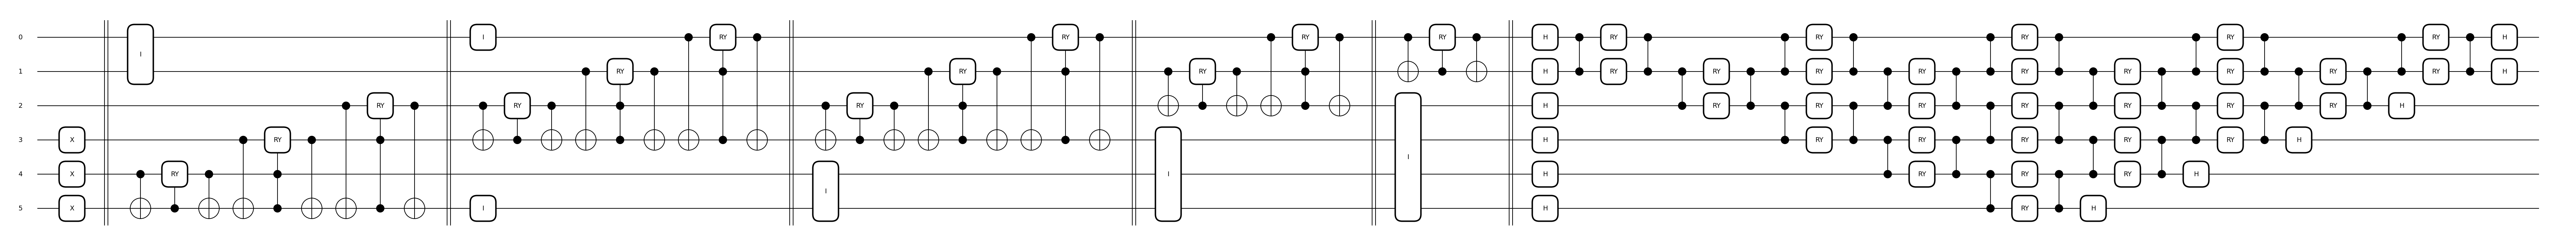

In [12]:
qubits = ham.wires
theta = np.zeros(15)
qml.draw_mpl(Ansatz2)(qubits, theta)

In [13]:
stp

NameError: name 'stp' is not defined

-----

In [ ]:
class QITE_Evolver:
    """
    A class to evolve a parametrized quantum state under the action of an Ising
    Hamiltonian using the variational Quantum Imaginary Time Evolution (QITE) principle.
    """
    def __init__(self, hamiltonian: qml.Hamiltonian, ansatz: str):
        self.hamiltonian = hamiltonian
        self.n_qubits = len(hamiltonian.wires)
        self.qubits = hamiltonian.wires
        self.ansatz = ansatz

        # History
        self.energies, self.param_vals, self.difference = [], [], []

        # Select Ansatz
        if self.ansatz == 'Ansatz 1':
            self.circuit = Ansatz1
            self.curr_params = np.zeros(15, requires_grad=True)
        elif self.ansatz == 'Ansatz 2':
            self.circuit = Ansatz2
            self.curr_params = np.random.uniform(0, 2*np.pi, 15, requires_grad=True)
        else:
            raise ValueError("Unsupported ansatz name")

        self.param_vals.append(self.curr_params.copy())
        self.device = qml.device("default.qubit", wires= self.qubits)

        # Create QNodes
        self._setup_qnodes()

    ### Qnode -> Quanutm Fucntions
    def _setup_qnodes(self):
        """
        Define QNodes for energy and metric tensor computation.
        """
        @qml.qnode(self.device)
        def energy_qnode(params):
            self.circuit(self.qubits, params)
            return qml.expval(self.hamiltonian)
        
        @qml.qnode(self.device)
        def prob_qnode(params):
            self.circuit(self.qubits, params)
            return qml.probs()
        
        @qml.qnode(self.device)
        def pauli_qnode(params):
            self.circuit(self.qubits, params)
            return np.array([qml.expval(op) for op in self.hamiltonian.ops])
        
        @qml.qnode(self.device)
        def pauli_ham_qnode(params):
            self.circuit(self.qubits, params)
            return np.array([qml.expval(op @ self.hamiltonian) for op in self.hamiltonian.ops])
        
        self.energy_qnode = energy_qnode
        self.pauli_qnode = pauli_qnode
        self.pauli_ham_qnode = pauli_ham_qnode
        self.prob_qnode = prob_qnode
        

    def get_defining_ode(self, curr_params):
        """
        Construct the dynamics matrix and load vector defining the varQITE iteration.
        """
        num_params = len(curr_params)

        curr_energy = self.energy_qnode(curr_params)

        grad_matrix = qml.jacobian(self.pauli_qnode)(curr_params)

        Gmat = np.zeros((len(self.hamiltonian.ops), num_params))
        for i in range(len(self.hamiltonian.ops)):
            for j in range(num_params):
                Gmat[i, j] = grad_matrix[i, j]  

        dvec = np.zeros(len(self.hamiltonian.ops))
        pauli_exps = self.pauli_qnode(curr_params)
        pauli_ham_exps = self.pauli_ham_qnode(curr_params)
        for i in range(len(self.hamiltonian.ops)):
            dvec[i] = - (pauli_ham_exps[i] - curr_energy * pauli_exps[i])

        return Gmat, dvec, curr_energy


    def evolve(self, num_steps: int, lr: float):
        """
        Run QITE evolution for a given number of steps with specified learning rate.
        """
        
        self.energies.append(self.energy_qnode(self.curr_params))
        patient = 0

        for k in range(num_steps):

            Gmat, dvec, curr_energy = self.get_defining_ode(self.curr_params)
            dcurr_params = np.linalg.lstsq(Gmat, dvec, rcond=1e-2)[0]
            self.curr_params += lr * dcurr_params

            if k > 2:
                diff = np.abs(self.energies[-1] - self.energies[-2])
                self.difference.append(diff)

                if diff <= 1e-7:
                    patient += 1
                elif diff > 1e-6:
                    patient = 0

                if patient >= 10:
                    break

            self.energies.append(curr_energy)
            self.param_vals.append(self.curr_params.copy())

    
    def plot_process(self):
        """
        Plot the convergence of the energy during QITE steps.
        """
        plt.plot(self.energies)
        plt.xlabel("Imaginary time step")
        plt.ylabel("Hamiltonian energy")
        plt.title("QITE Convergence")
        plt.grid(True)
        plt.show()

    def plot_decaying(self):
        """
        Plot the difference of the energy for each before step
        """ 
        plt.plot(self.differences)
        plt.xlabel("Imaginary time step")
        plt.ylabel("Hamiltonian energy difference compared to the last step")
        plt.title("QITE Convergence")
        plt.grid(True)
        plt.show()

    def circuit_final_result(self):
        """
        Return the circuit's probability of each states
        """

        @qml.qnode(self.device)
        def circuit():
            self.circuit(self.qubits, self.param_vals[-1])
            return qml.probs()
        
        state_prob = circuit()
        return state_prob


-----

### Utilities for saving datas

In [15]:
def calc_mass(pred):
    mass = 0
    for i in range(len(pred)):
        for j in range(len(pred)):
            _, p_ix, p_iy, p_iz, e_i = pred[i]
            _, p_jx, p_jy, p_jz, e_j = pred[j]
            mass += e_i * e_j - p_ix * p_jx - p_iy * p_jy - p_iz * p_jz

    return np.sqrt(mass)

def dividing_particles(event, bit_string):

    A = []
    B = []

    for i, bit in enumerate(bit_string):
        if bit == '1':
            A.append(event[i])
        else:
            B.append(event[i])
    
    return A, B

In [16]:
def eigenvector_to_bit(arr):
    indices = np.where(arr != 0)[0]
    bitstrings = [format(index, '06b') for index in indices]
    return bitstrings

def _prob_result(prob_result):
    num_states = len(prob_result)
    bit_dim = int(np.log2(num_states))
    states = [bin(i)[2:].zfill(bit_dim) for i in range(2**bit_dim)]

    results = dict()
    for i in range(num_states):
        results[states[i]] = prob_result[i]

    results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    return results

------

------

### Algorithm Running

In [17]:
import os

In [18]:
def QITE_run(events, event_idx, ham_type, ansatz):
    event = event_selection(events, event_idx)

    p = momentum_vector(event)
        
    H_p = build_hamiltonian(event, ham_type)
    H_mat = qml.matrix(H_p)

    eigenvalues, eigenvectors = np.linalg.eigh(H_mat)

    eigenvec = []
    for i in range(len(eigenvalues)):
        eigenvec.append(eigenvector_to_bit(eigenvectors[:, i]))

    eigenvec = np.array(eigenvec)

    qit_evolver = QITE_Evolver(H_p, ansatz = ansatz)
    qit_evolver.evolve(num_steps=1000, lr=0.5)

    prob_result = qit_evolver.circuit_final_result()
    results = _prob_result(prob_result)
    ans_state = results[0][0]
   

    A, B = dividing_particles(event, ans_state)
    mass_A, mass_B = calc_mass(A), calc_mass(B)
    mass_division = np.array([mass_A, mass_B])

    return [p, H_mat, eigenvalues, np.array(eigenvec), np.array(qit_evolver.energies), qit_evolver.param_vals, np.array(qit_evolver.difference), results, mass_division]


  0%|          | 0/1 [00:00<?, ?it/s]

(<Figure size 7500x700 with 1 Axes>, <Axes: >)
(<Figure size 7500x700 with 1 Axes>, <Axes: >)


/opt/miniconda3/envs/Pennylane_QITE/lib/python3.12/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)
100%|██████████| 1/1 [01:13<00:00, 73.32s/it]


Analyzed Event Data : 1


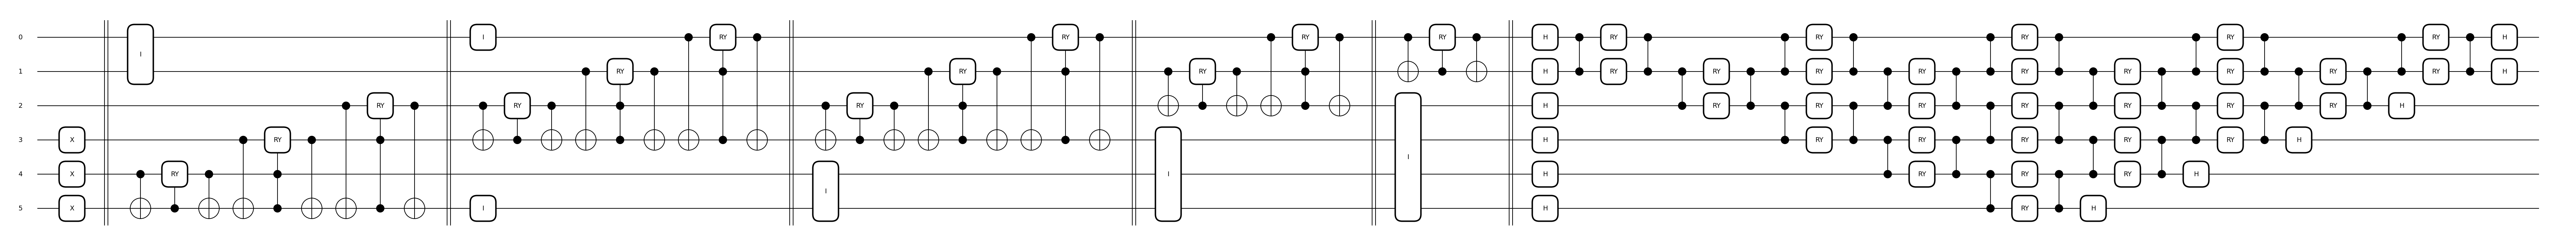

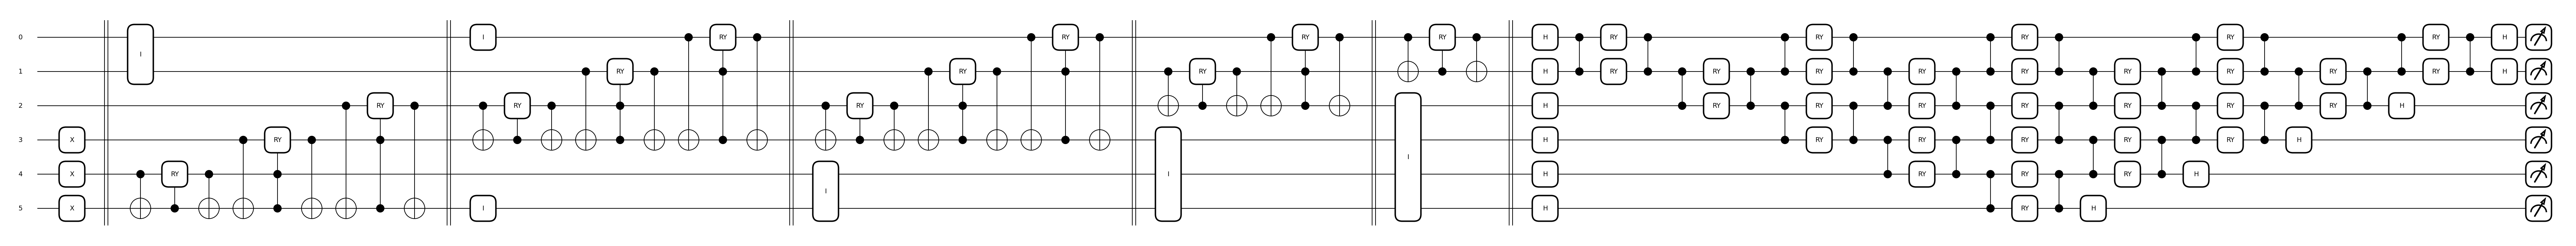

In [19]:
### File path
lhe_file_path = "./Data/tt_bar_6j.lhe.gz"

# Extract 4-momentum data (10000 Events)
events = lhe_4momenta(lhe_file_path)

ham_type = 'H0'             # H0 / H1 / H2
ansatz_type = 'Ansatz 2'    # Ansatz 1 / Ansatz 2
val = 0

path = f'./(ttbar)Analysis/{ansatz_type}, {ham_type}'

for i in tqdm(range(1)):
    event_idx = np.random.randint(10000)
    
    file_list = os.listdir(path)
    name = f'Event__{event_idx}.npz'
    
    if name in file_list:

        continue

    else:

        result = QITE_run(events, event_idx, ham_type, ansatz_type)

#        np.savez(f'./(ttbar)Analysis/{ansatz_type}, {ham_type}/Event__{event_idx}',
#             Momentum = result[0],           
#             Hamiltonian = result[1],
#             Eigenvalues = result[2],
#             Eigenvector= result[3],
#             QITE_Evolving = result[4],
#             Parameters = result[5],
#             Difference_Convergence = result[6],
#             Simulation_Result = result[7],
#             Mass_Division = result[8])
        
        val += 1

print(f"Analyzed Event Data : {val}")
